Исходное изображение:


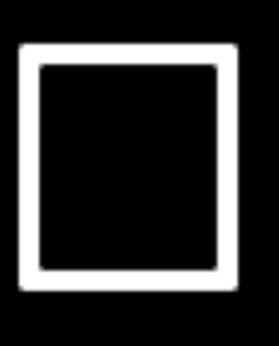

Введите threshold- значение: 
10
Результат:


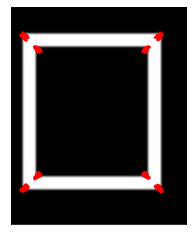

Время выполнения на GPU:  0.001708267999902091
Время выполнения на CPU:  0.0028386159999627125
Ускорение:  1.6616924277252791


In [ ]:
!pip install pycuda
import matplotlib.pyplot as plt
import timeit
import cv2
from google.colab.patches import cv2_imshow
import pycuda.autoinit
from string import Template
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

def harris_gpu(img, k, thresh):

    height = img.shape[0]
    width = img.shape[1]

    vector_size = img.shape[0] * img.shape[1]
    corner_list = []
    offset = 2
    
    thresh = int(thresh/10)

    func_mod_template = Template("""
    #include<stdio.h>
    #define INDEX(a, b) a*${HEIGHT}+b

    __global__ void corners(
        float *dest,
        float *ixx,
        float *ixy,
        float *iyy,
        int offset,
        float k,
        int threshold) {

        unsigned int idx = threadIdx.x + threadIdx.y*blockDim.y +
                            (blockIdx.x*(blockDim.x*blockDim.y));

        unsigned int a = idx/${HEIGHT};
        unsigned int b = idx%${HEIGHT};

        float sxx = 0;
        float sxy = 0;
        float syy = 0;
        float det = 0;
        float trace = 0;
        float r = 0;

        if ((a >= offset) & (a <= (${WIDTH}-offset - 1)) &
            (b >= offset) & (b <= (${HEIGHT}-offset - 1))) {
            for (int bi = b - offset; bi < b + offset + 1; ++bi) {
                for (int ai = a - offset; ai < a + offset + 1; ++ai) {
                    sxx = sxx + ixx[INDEX(ai, bi)];
                    sxy = sxy + ixy[INDEX(ai, bi)];
                    syy = syy + iyy[INDEX(ai, bi)];
                }
            }
            det = sxx*syy - sxy*sxy;
            trace = sxx + syy;
            r = det - k*(trace*trace);
            if ((r/10) > threshold)
                dest[INDEX(a, b)] = r;
        }
    }
    """)

    func_mod = SourceModule(func_mod_template.substitute(HEIGHT=height,
                                                         WIDTH=width))
    pycuda_corners = func_mod.get_function("corners")

    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2

    ixx = Ixx.reshape(vector_size, order='F')
    ixy = Ixy.reshape(vector_size, order='F')
    iyy = Iyy.reshape(vector_size, order='F')
    dest_r = np.zeros_like(ixx)

    start = timeit.default_timer()

    pycuda_corners(drv.Out(dest_r),
                drv.In(ixx),
                drv.In(ixy),
                drv.In(iyy),
                np.uint32(offset),
                np.float32(k),
                np.uint32(thresh),
                block=(32, 32, 1),  
                grid=(height*width//1024, 1, 1))  
    
    execution_time = timeit.default_timer() - start

    r = np.reshape(dest_r, (height, width), order='F')
    corners = np.where(r > 0)
    for i, j in zip(corners[0], corners[1]):
        corner_list.append([j, i, r[i, j]])

    return corner_list, execution_time

# Загружаем исходное изображение
image = cv2.imread('sample_data/input.png', 0).astype(np.float32)
print('Исходное изображение:')
cv2_imshow(image)
print("Введите threshold- значение: ")
thresh = int(input())
k = 0.05

# Вызываем GPU:
corners, timed = harris_gpu(image, k, thresh)

# Выведем результат работы программы:
print("Результат:")
n_image = np.zeros(image.shape) 
fig = plt.imshow(image, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.scatter([x[0] for x in corners], [x[1] for x in corners], s=1, c = 'red')
plt.savefig('sample_data/output.png')
plt.show()

# Вызываем CPU:
start = timeit.default_timer()
dst = cv2.cornerHarris(image,2,3,0.05)
cv2_time = timeit.default_timer() - start

print("Время выполнения на GPU: ", timed)
print("Время выполнения на CPU: ", cv2_time)
print("Ускорение: ", cv2_time/timed)